# Práctica Final Deep Learning

Para esta practica nos hemos basado en el paper titulado "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", se compara el rendimiento de un modelo Vision Transformer (ViT) y un modelo de Convolutional Neural Network (CNN) en una tarea de clasificación de imágenes.

Hemos querido explorar cómo los transformadores, originalmente diseñados para tareas de procesamiento de lenguaje natural, pueden ser adaptados y aplicados eficazmente en el ámbito del reconocimiento de imágenes, comparándolos con los tradicionales modelos de redes neuronales convolucionales.

## Importación de las librerías

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Layer, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import custom_object_scope

## Importación del conjunto de datos

In [ ]:
def load_dataset():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
    x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test
x_train, y_train, x_test, y_test = load_dataset()

11490434/11490434 [==============================] - 0s 0us/step


Se importa el conjunto de MNIST de numeros del 0-9 manuscritos para su posterior clasificación.

## Exploración del conjunto de datos

In [ ]:
print("Se dispone de", x_train.shape[0], "imágenes y etiquetas de entrenamiento.")
print("Se dispone de", x_test.shape[0], "imágenes y etiquetas de test.")
print("La dimensión de cada imagen es", x_train.shape[1:])

Se dispone de 60000 imágenes y etiquetas de entrenamiento.
Se dispone de 10000 imágenes y etiquetas de test.
La dimensión de cada imagen es (28, 28, 1)


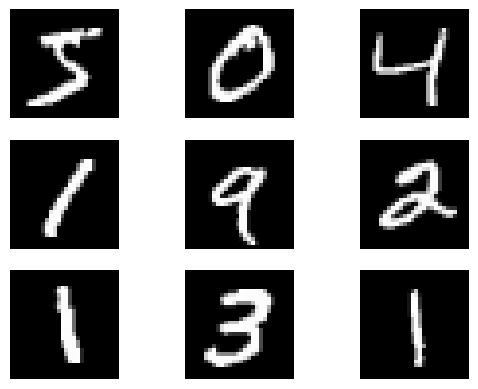

In [ ]:
for i in range(9):
 plt.subplot(330 + 1 + i)
 plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
 plt.axis('off')
plt.show()

Se estudia la distribución de las distintas clases, es decir, los números que aparecen en las imágenes.

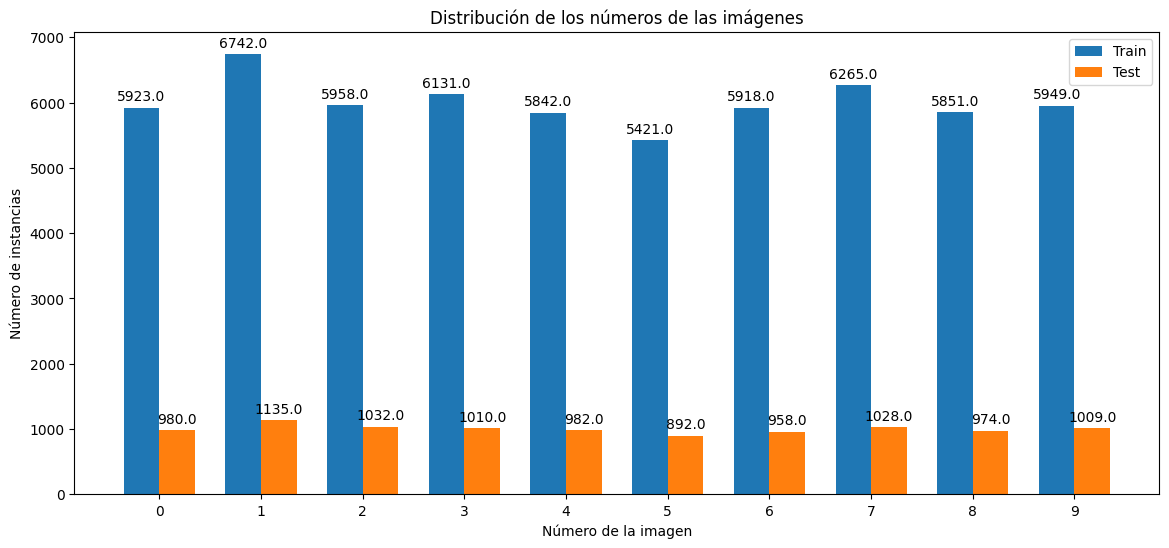

In [ ]:
# Suma los vectores one-hot para cada clase para obtener la cantidad de instancias por clase
# y_train e y_test tienen forma (n_samples, 10), donde 10 representa las clases del 0 al 9
train_counts = np.sum(y_train, axis=0)
test_counts = np.sum(y_test, axis=0)

# Crear las etiquetas para el eje x del histograma
labels = range(10)  # Clases de 0 a 9

# Configurar los parámetros de la gráfica
x = np.arange(len(labels))  # Las etiquetas de clase en el eje x
width = 0.35  # El ancho de las barras

fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
rects2 = ax.bar(x + width/2, test_counts, width, label='Test')

# Añadir algunas etiquetas y título
ax.set_xlabel('Número de la imagen')
ax.set_ylabel('Número de instancias')
ax.set_title('Distribución de los números de las imágenes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Función para añadir las etiquetas de datos en cada barra
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Mostrar la gráfica
plt.show()


Se observa una buena distribución entre test y train homogenea entre todas las categorias.

## Preprocesamiento del conjunto de datos

Se escalan entre 0 y 1 los valores de los píxeles de las imágenes.

In [ ]:
# Se escalan los valores de los píxeles entre 0 y 1
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

Se obtiene el subconjunto de datos de validación.

In [ ]:
# Dividir los datos de entrenamiento en un nuevo conjunto de entrenamiento y validación
x_train_new, x_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42)

Se utiliza la técnica Data Augmentation. Esta tecnica consiste en aplicar una cantidad pequeña de rotaciones, reescalas y cambios de color con el objetivo de aumentar el numero de variabilidad de las imagenes imagenes que procesa la red neuronal con el objetivo de mejorar su precision. Para esto usamos la clase ImageDataGenerator de Keras.

In [ ]:
# Crear el generador para datos de entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Crear el generador para datos de validación sin data augmentation
val_datagen = ImageDataGenerator()

# Configurar los generadores
train_generator = train_datagen.flow(x_train_new, y_train_new, batch_size=32)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32)

## Definición de los modelos

Ya que los Vision Transformers tienen el objetivo de implantar soluciones mas eficientes al tener menor numero de parametros y ser mas rapidas, de clasificar imagenes hemos querido comparar el rendimiento de las redes CNN contra las ViT.

Para ello primero diseñamos una red convolucional de capas convolucionales, operaciones de max pooling, redes densas, dropout y finalmetne una capa de 10 neuronas con funcion de activacion softmax para poder clasificar correctamente los numeros.

### Red convolucional

In [ ]:
model_CNN = Sequential([
    # Capa convolucional, extracción de características
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Aplanar la salida
    Flatten(),

    # Capa densa
    Dense(64, activation='relu'),
    Dropout(0.5),  # Dropout para reducir el overfitting
    Dense(10, activation='softmax')  # Capa de salida para las 10 clases
])

model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                1

Se compila el modelo utilizando categorical_crossentropy como metrica de perdida ya que es el mejor para la clasificacion multiclase como es este caso.

In [ ]:
model_CNN.compile(
    optimizer='adam',  # Optimizador robusto
    loss='categorical_crossentropy',  # Adecuado para clasificación multiclase
    metrics=['accuracy']
)

### Vision Transformer

Los Vision Transformers (ViT) comienzan procesando una imagen dividiéndola en múltiples parches fijos, cada uno de los cuales se transforma en un vector a través de una capa densa. Para incorporar la posición relativa de cada parche, se añaden embeddings de posición a estos vectores. Los vectores resultantes se alimentan a través de una serie de capas de Transformer, que utilizan atención multi-cabeza para permitir al modelo enfocarse en diferentes partes de la imagen simultáneamente. La información de todos los parches se combina en capas sucesivas, permitiendo que el modelo capture relaciones complejas entre diferentes áreas de la imagen. Finalmente, la salida de la última capa de Transformer se utiliza para clasificar la imagen o para realizar otras tareas de visión computacional.

In [ ]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        # Usar tf.shape para obtener dimensiones en tiempo de ejecución
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        # Calcular dinámicamente el número de parches y la dimensión de cada parche
        num_patches = tf.shape(patches)[1] * tf.shape(patches)[2]
        patch_dims = tf.shape(patches)[-1]
        patches = tf.reshape(patches, [batch_size, num_patches, patch_dims])
        return patches

class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = self.add_weight(
            "position_embedding", shape=(1, num_patches + 1, projection_dim))

    def call(self, patch):
        # Proyectar los patches a la dimensión deseada
        encoded = self.projection(patch)
        # Crear una secuencia de posiciones
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # Usar tf.gather para seleccionar embeddings de posición basados en 'positions'
        position_embedding = tf.gather(self.position_embedding, positions, axis=1)
        # Sumar el embedding de posición a los patches proyectados
        encoded += position_embedding
        return encoded

class TransformerBlock(Layer):
    def __init__(self, projection_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(projection_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_vit_classifier():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    # Resize para tener un tamaño más adecuado para los parches
    resized = tf.keras.layers.Resizing(32, 32)(inputs)
    # Crear parches
    patches = Patches(patch_size=4)(resized)
    # Codificar parches
    encoded_patches = PatchEncoder(num_patches=64, projection_dim=64)(patches)

    # Bloques Transformer
    x = TransformerBlock(64, 8, 128)(encoded_patches)
    x = TransformerBlock(64, 8, 128)(x)

    # Clasificador
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = Dense(10, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model_ViT = create_vit_classifier()
model_ViT.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 patches (Patches)           (None, 64, 16)            0         
                                                                 
 patch_encoder (PatchEncode  (None, 64, 64)            5248      
 r)                                                              
                                                                 
 transformer_block (Transfo  (None, 64, 64)            149504    
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  (None, 64, 64)            149504

Se compila el modelo.

In [ ]:
model_ViT.compile(
    optimizer='adam',  # Optimizador robusto
    loss='categorical_crossentropy',  # Adecuado para clasificación multiclase
    metrics=['accuracy']
)

## Entrenamiento

Se definen los callbacks; early_Stopping para parar el entrenamiento si la metrica de validacion no mejora despues de 5 epocas, model_checkpoint guarda el mejor modelo basado en el 'val_loss'

In [ ]:
# Crear el callback de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=5,         # Número de épocas sin mejora tras las cuales se detiene el entrenamiento
    verbose=1,           # Muestra mensajes cuando se detiene el entrenamiento
    restore_best_weights=True  # Restaura los pesos del modelo con el mejor valor de la cantidad monitoreada
)

# Crear el callback de ModelCheckpoint para la CNN
model_checkpoint_cnn = ModelCheckpoint(
    'best_model_cnn.h5',   # Nombre del archivo donde se guardarán los pesos del modelo
    monitor='val_loss',  # Monitorea la pérdida de validación
    save_best_only=True,  # Guarda solo cuando su versión es mejor que la anterior
    verbose=1            # Muestra información detallada durante el entrenamiento
)

# Crear el callback de ModelCheckpoint para el ViT
model_checkpoint_ViT = ModelCheckpoint(
    'best_model_ViT.h5',   # Nombre del archivo donde se guardarán los pesos del modelo
    monitor='val_loss',  # Monitorea la pérdida de validación
    save_best_only=True,  # Guarda solo cuando su versión es mejor que la anterior
    verbose=1            # Muestra información detallada durante el entrenamiento
)

### Red convolucional

In [ ]:
history = model_CNN.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint_cnn]  # Usar los callbacks definidos
)

Epoch 1/50
1684/1688 [============================>.] - ETA: 0s - loss: 0.5994 - accuracy: 0.8060
Epoch 1: val_loss improved from inf to 0.07237, saving model to best_model_cnn.h5
1688/1688 [==============================] - 22s 12ms/step - loss: 0.5987 - accuracy: 0.8063 - val_loss: 0.0724 - val_accuracy: 0.9795
Epoch 2/50
  11/1688 [..............................] - ETA: 18s - loss: 0.3034 - accuracy: 0.9034

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1686/1688 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.9210
Epoch 2: val_loss improved from 0.07237 to 0.05000, saving model to best_model_cnn.h5
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2591 - accuracy: 0.9209 - val_loss: 0.0500 - val_accuracy: 0.9848
Epoch 3/50
1687/1688 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9425
Epoch 3: val_loss improved from 0.05000 to 0.04601, saving model to best_model_cnn.h5
1688/1688 [==============================] - 20s 12ms/step - loss: 0.1889 - accuracy: 0.9425 - val_loss: 0.0460 - val_accuracy: 0.9840
Epoch 4/50
1685/1688 [============================>.] - ETA: 0s - loss: 0.1611 - accuracy: 0.9535
Epoch 4: val_loss improved from 0.04601 to 0.04098, saving model to best_model_cnn.h5
1688/1688 [==============================] - 20s 12ms/step - loss: 0.1610 - accuracy: 0.9536 - val_loss: 0.0410 - val_accuracy: 0.9883
Epoch 5/50
1688/1688 [==============================] 

Visualización del entrenamiento.

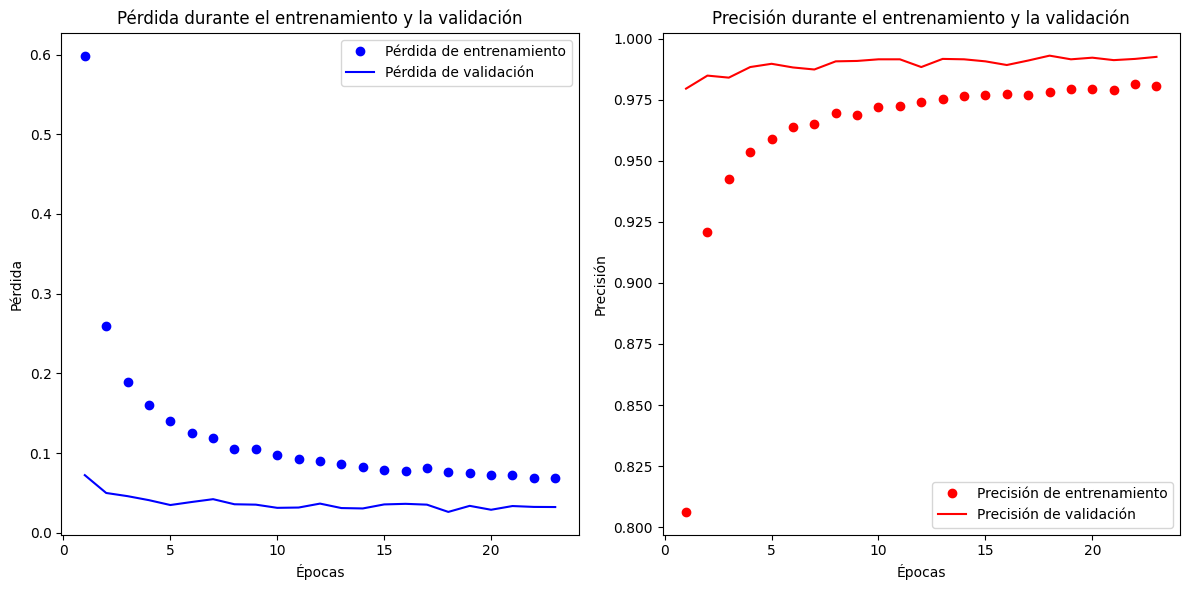

In [ ]:
# Accediendo a los valores de pérdida y precisión
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Creando gráficos de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Creando gráficos de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'ro', label='Precisión de entrenamiento')
plt.plot(epochs, val_accuracy, 'r', label='Precisión de validación')
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

La pérdida de entrenamiento disminuye consistentemente a lo largo de las épocas, lo que indica que el modelo está aprendiendo y ajustándose a los datos de entrenamiento. La pérdida de validación también disminuye al principio, pero con fluctuaciones más notables en comparación con la pérdida de entrenamiento.
Estas muestran los puntos donde el modelo está ajustándose a los datos de validación.

Por otro lado, la precisión de entrenamiento aumenta rápidamente en las primeras épocas, alcanzando un nivel de un 97% antes de las primeras 5 epocas.

### Vision Transformer

In [ ]:
history = model_ViT.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint_ViT]  # Usar los callbacks definidos
)

Epoch 1/50
1688/1688 [==============================] - ETA: 0s - loss: 0.7454 - accuracy: 0.7481
Epoch 1: val_loss improved from inf to 0.22710, saving model to best_model_ViT.h5
1688/1688 [==============================] - 153s 89ms/step - loss: 0.7454 - accuracy: 0.7481 - val_loss: 0.2271 - val_accuracy: 0.9290
Epoch 2/50
1688/1688 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.9197
Epoch 2: val_loss improved from 0.22710 to 0.12998, saving model to best_model_ViT.h5
1688/1688 [==============================] - 146s 87ms/step - loss: 0.2517 - accuracy: 0.9197 - val_loss: 0.1300 - val_accuracy: 0.9613
Epoch 3/50
1688/1688 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9410
Epoch 3: val_loss improved from 0.12998 to 0.12995, saving model to best_model_ViT.h5
1688/1688 [==============================] - 145s 86ms/step - loss: 0.1882 - accuracy: 0.9410 - val_loss: 0.1300 - val_accuracy: 0.9598
Epoch 4/50
1688/1688 [======================

Visualización del entrenamiento.

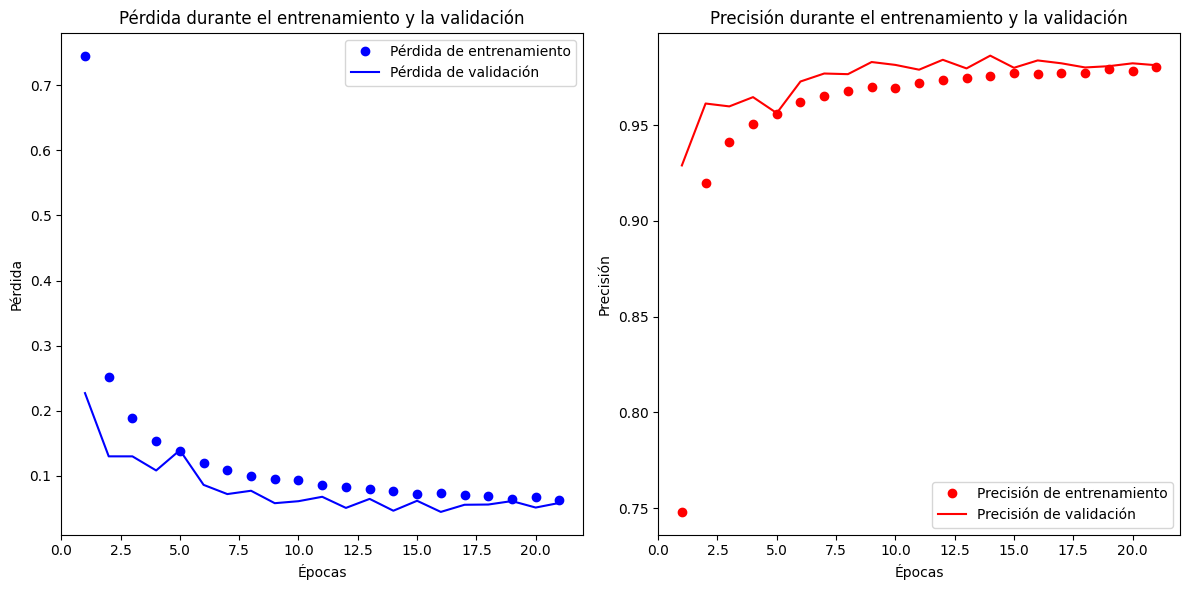

In [ ]:
# Accediendo a los valores de pérdida y precisión
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Creando gráficos de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Creando gráficos de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'ro', label='Precisión de entrenamiento')
plt.plot(epochs, val_accuracy, 'r', label='Precisión de validación')
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

En comparacion con el modelo CNN ambas arquitecturas muestran una pérdida de entrenamiento y validación muy baja y similar al igual que ocurre con la precisión, indicando que ambos modelos aprenden bien los datos de entrenamiento.

## Evaluación de los modelos

### Red convolucional

In [ ]:
# Cargar el mejor modelo guardado durante el entrenamiento
model_cnn = load_model('best_model_cnn.h5')

test_loss, test_acc = model_cnn.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0205 - accuracy: 0.9940
Test accuracy: 0.9940


### Vision Transformer

In [ ]:
# Cargar el mejor modelo guardado durante el entrenamiento
with custom_object_scope({'Patches': Patches, 'PatchEncoder': PatchEncoder, 'TransformerBlock': TransformerBlock}):
    model_ViT = load_model('best_model_ViT.h5')

test_loss, test_acc = model_ViT.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 [==============================] - 12s 38ms/step - loss: 0.0428 - accuracy: 0.9859
Test accuracy: 0.9859


Con un set de datos menor vemos que el vision transformer obtiene una precision menos de un 1 porceinto menor al CNN aunque ambos resultados son muy positivos.

## Prueba con CIFAR-10

### Importación del conjunto de datos

In [ ]:
def load_dataset():
    from tensorflow.keras.datasets import cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # Normalizar los datos de entrada
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255
    # Convertir etiquetas a one-hot encoding
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_dataset()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 10)


Se importa la clase de CIFAR10, que contiene 60,000 imágenes de 10 clases diferentes, con 50,000 imágenes para entrenamiento y 10,000 para prueba y se visualizan 7 imagenes del dataset

### Exploración del conjunto de datos

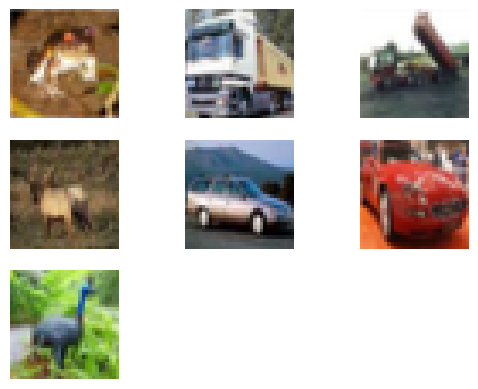

In [ ]:
for i in range(7):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.show()


### Preprocesamiento del conjunto de datos

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator()

# Definir tamaño de lote
batch_size = 32

# Configurar los generadores
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_test, y_test, batch_size=batch_size)


Los datos se preprocesan al igual que en el caso anterior

### Actualización de los modelos

#### CNN

In [ ]:
model_CNN = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


In [ ]:
model_CNN.compile(
    optimizer='adam',  # Optimizador robusto
    loss='categorical_crossentropy',  # Adecuado para clasificación multiclase
    metrics=['accuracy']
)

#### Vision Transformer

In [ ]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        # Usar tf.shape para obtener dimensiones en tiempo de ejecución
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        # Calcular dinámicamente el número de parches y la dimensión de cada parche
        num_patches = tf.shape(patches)[1] * tf.shape(patches)[2]
        patch_dims = tf.shape(patches)[-1]
        patches = tf.reshape(patches, [batch_size, num_patches, patch_dims])
        return patches

class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = self.add_weight(
            "position_embedding", shape=(1, num_patches + 1, projection_dim))

    def call(self, patch):
        # Proyectar los patches a la dimensión deseada
        encoded = self.projection(patch)
        # Crear una secuencia de posiciones
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # Usar tf.gather para seleccionar embeddings de posición basados en 'positions'
        position_embedding = tf.gather(self.position_embedding, positions, axis=1)
        # Sumar el embedding de posición a los patches proyectados
        encoded += position_embedding
        return encoded

class TransformerBlock(Layer):
    def __init__(self, projection_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(projection_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_vit_classifier():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    # Crear parches
    patches = Patches(patch_size=4)(inputs)
    # Codificar parches
    encoded_patches = PatchEncoder(num_patches=64, projection_dim=64)(patches)

    # Bloques Transformer
    x = TransformerBlock(64, 8, 128)(encoded_patches)
    x = TransformerBlock(64, 8, 128)(x)

    # Clasificador
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = Dense(10, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model_ViT = create_vit_classifier()
model_ViT.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 patches_2 (Patches)         (None, 64, 48)            0         
                                                                 
 patch_encoder_2 (PatchEnco  (None, 64, 64)            7296      
 der)                                                            
                                                                 
 transformer_block_4 (Trans  (None, 64, 64)            149504    
 formerBlock)                                                    
                                                                 
 transformer_block_5 (Trans  (None, 64, 64)            149504    
 formerBlock)                                                    
                                                           

In [ ]:
model_ViT.compile(
    optimizer='adam',  # Optimizador robusto
    loss='categorical_crossentropy',  # Adecuado para clasificación multiclase
    metrics=['accuracy']
)

### Entrenamiento

Se definen los callbacks.

In [ ]:
# Crear el callback de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=5,         # Número de épocas sin mejora tras las cuales se detiene el entrenamiento
    verbose=1,           # Muestra mensajes cuando se detiene el entrenamiento
    restore_best_weights=True  # Restaura los pesos del modelo con el mejor valor de la cantidad monitoreada
)

# Crear el callback de ModelCheckpoint para la CNN
model_checkpoint_cnn = ModelCheckpoint(
    'best_model_cnn.h5',   # Nombre del archivo donde se guardarán los pesos del modelo
    monitor='val_loss',  # Monitorea la pérdida de validación
    save_best_only=True,  # Guarda solo cuando su versión es mejor que la anterior
    verbose=1            # Muestra información detallada durante el entrenamiento
)

# Crear el callback de ModelCheckpoint para el ViT
model_checkpoint_ViT = ModelCheckpoint(
    'best_model_ViT.h5',   # Nombre del archivo donde se guardarán los pesos del modelo
    monitor='val_loss',  # Monitorea la pérdida de validación
    save_best_only=True,  # Guarda solo cuando su versión es mejor que la anterior
    verbose=1            # Muestra información detallada durante el entrenamiento
)

Se definen los mismos callbacks

#### Red convolucional

In [ ]:
history = model_CNN.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint_cnn]  # Usar los callbacks definidos
)

Epoch 1/50
1562/1563 [============================>.] - ETA: 0s - loss: 1.8086 - accuracy: 0.3283
Epoch 1: val_loss improved from inf to 1.38609, saving model to best_model_cnn.h5
1563/1563 [==============================] - 32s 20ms/step - loss: 1.8087 - accuracy: 0.3283 - val_loss: 1.3861 - val_accuracy: 0.5061
Epoch 2/50
1561/1563 [============================>.] - ETA: 0s - loss: 1.5715 - accuracy: 0.4248
Epoch 2: val_loss improved from 1.38609 to 1.30276, saving model to best_model_cnn.h5
1563/1563 [==============================] - 31s 20ms/step - loss: 1.5714 - accuracy: 0.4249 - val_loss: 1.3028 - val_accuracy: 0.5275
Epoch 3/50
1561/1563 [============================>.] - ETA: 0s - loss: 1.4784 - accuracy: 0.4648
Epoch 3: val_loss improved from 1.30276 to 1.24179, saving model to best_model_cnn.h5
1563/1563 [==============================] - 31s 20ms/step - loss: 1.4787 - accuracy: 0.4647 - val_loss: 1.2418 - val_accuracy: 0.5563
Epoch 4/50
1561/1563 [=========================

Visualización del entrenamiento.

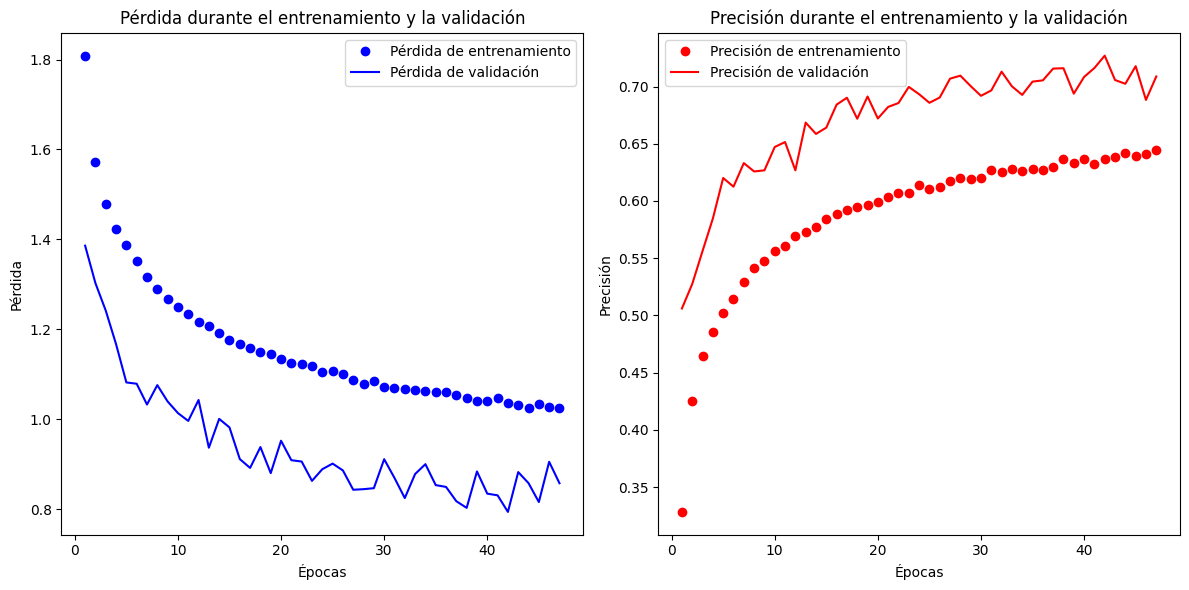

In [ ]:
# Accediendo a los valores de pérdida y precisión
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Creando gráficos de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Creando gráficos de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'ro', label='Precisión de entrenamiento')
plt.plot(epochs, val_accuracy, 'r', label='Precisión de validación')
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

#### Vision Transformer

In [ ]:
history = model_ViT.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint_ViT]  # Usar los callbacks definidos
)

Epoch 1/50
1563/1563 [==============================] - ETA: 0s - loss: 1.7515 - accuracy: 0.3501
Epoch 1: val_loss improved from inf to 1.46174, saving model to best_model_ViT.h5
1563/1563 [==============================] - 142s 88ms/step - loss: 1.7515 - accuracy: 0.3501 - val_loss: 1.4617 - val_accuracy: 0.4728
Epoch 2/50
1563/1563 [==============================] - ETA: 0s - loss: 1.4731 - accuracy: 0.4651
Epoch 2: val_loss improved from 1.46174 to 1.32720, saving model to best_model_ViT.h5
1563/1563 [==============================] - 138s 88ms/step - loss: 1.4731 - accuracy: 0.4651 - val_loss: 1.3272 - val_accuracy: 0.5201
Epoch 3/50
1563/1563 [==============================] - ETA: 0s - loss: 1.3731 - accuracy: 0.5035
Epoch 3: val_loss improved from 1.32720 to 1.29460, saving model to best_model_ViT.h5
1563/1563 [==============================] - 138s 89ms/step - loss: 1.3731 - accuracy: 0.5035 - val_loss: 1.2946 - val_accuracy: 0.5252
Epoch 4/50
1563/1563 [======================

Visualización del entrenamiento.

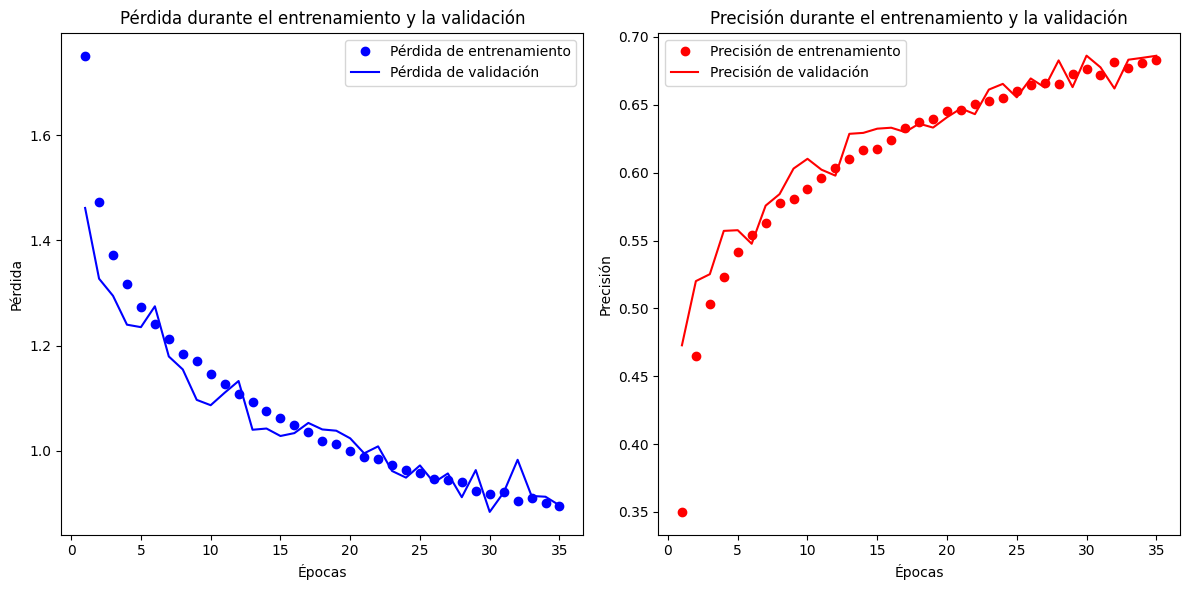

In [ ]:
# Accediendo a los valores de pérdida y precisión
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Creando gráficos de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Creando gráficos de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'ro', label='Precisión de entrenamiento')
plt.plot(epochs, val_accuracy, 'r', label='Precisión de validación')
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

La CNN muestra una pérdida de validación más baja y estable en comparación con el ViT. POr otro lado las fluctuaciones en la pérdida de validación son más pronunciadas en el ViT, lo que indica una mayor variabilidad, es decir, que el modelo de ViT es capaz de centrarse mejor en distintos tipos de imagen de una misma clase pero con diferencias.

### Evaluación de los modelos

#### Red convolucional

In [ ]:
# Cargar el mejor modelo guardado durante el entrenamiento
model_cnn = load_model('best_model_cnn.h5')

test_loss, test_acc = model_cnn.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.7941 - accuracy: 0.7270
Test accuracy: 0.7270


#### Vision Transformer

In [ ]:
# Cargar el mejor modelo guardado durante el entrenamiento
with custom_object_scope({'Patches': Patches, 'PatchEncoder': PatchEncoder, 'TransformerBlock': TransformerBlock}):
    model_ViT = load_model('best_model_ViT.h5')

test_loss, test_acc = model_ViT.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 [==============================] - 12s 38ms/step - loss: 0.8835 - accuracy: 0.6862
Test accuracy: 0.6862


## Conclusiones

Se observa que los 2 modelos son bastante similares en cuanto a su buen rendimiento, siendo ligeramente mejor la red convolucional. Sin embargo, dada la poca diferencia entre ellos, en otros contextos podría funcionar mejor el Vision Transformer.